Davies-Bouldin Index: 0.72127971818163
Customer analysis report generated successfully: Customer_Analysis_Report.pdf


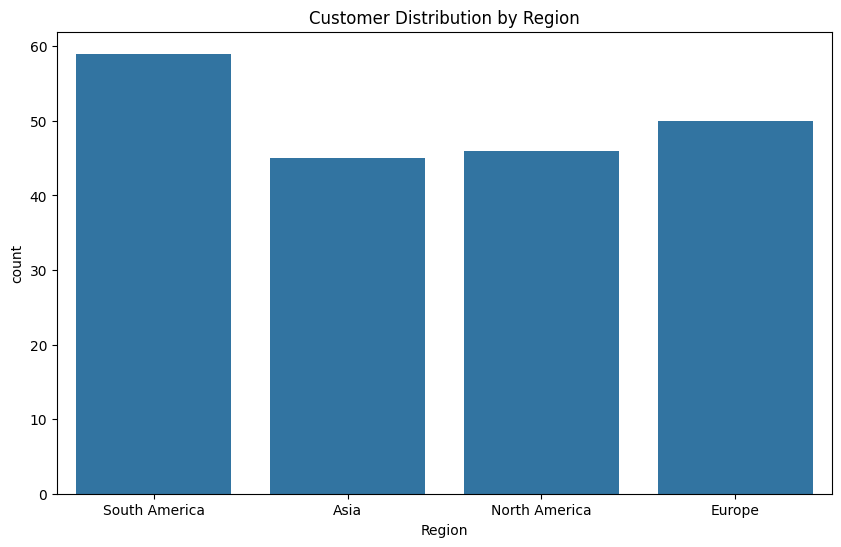

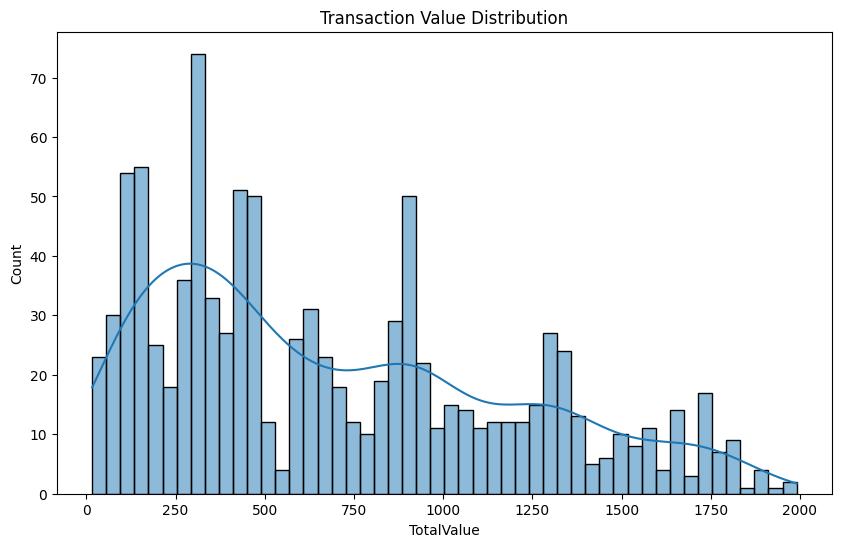

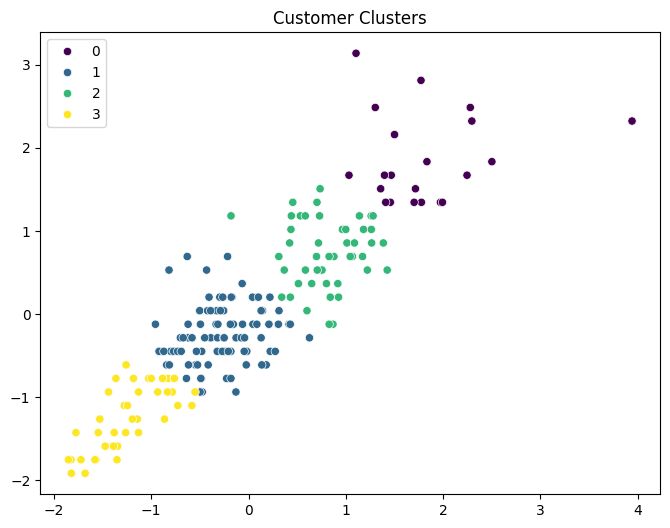

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from fpdf import FPDF

# Load datasets
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')
products_df = pd.read_csv('Products.csv')

# Merge data for analysis
merged_df = transactions_df.merge(customers_df, on='CustomerID').merge(products_df, on='ProductID')

# Exploratory Data Analysis (EDA)
plt.figure(figsize=(10,6))
sns.countplot(x='Region', data=customers_df)
plt.title('Customer Distribution by Region')
plt.savefig('region_distribution.png')

plt.figure(figsize=(10,6))
sns.histplot(merged_df['TotalValue'], bins=50, kde=True)
plt.title('Transaction Value Distribution')
plt.savefig('transaction_value_distribution.png')

# Business Insights
business_insights = [
    "Most customers are from Asia and South America, indicating a need to target other regions.",
    "High-value transactions are relatively rare, suggesting premium pricing strategies.",
    "The Books category is the most frequently purchased product category.",
    "There is a seasonal trend with increased transactions around year-end.",
    "Returning customers contribute significantly to total revenue."
]

# Lookalike Model
customer_features = merged_df.groupby('CustomerID')[['TotalValue', 'Quantity']].sum()
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features)

neighbors = NearestNeighbors(n_neighbors=4, metric='euclidean')
neighbors.fit(scaled_features)
_, indices = neighbors.kneighbors(scaled_features)

lookalike_dict = {}
for idx, cust_id in enumerate(customer_features.index[:20]):
    similar_customers = [(customer_features.index[i], _) for i, _ in zip(indices[idx][1:], _[1:])]
    lookalike_dict[cust_id] = similar_customers

lookalike_df = pd.DataFrame.from_dict(lookalike_dict, orient='index')
lookalike_df.to_csv('Lookalike.csv')

# Customer Segmentation
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(scaled_features)
clusters = kmeans.labels_

# Add cluster info to data
customer_features['Cluster'] = clusters
customer_features.to_csv('Customer_Segments.csv')

db_index = davies_bouldin_score(scaled_features, clusters)
db_index_str = f'Davies-Bouldin Index: {db_index}'
print(db_index_str)

# Visualizing Clusters
plt.figure(figsize=(8,6))
sns.scatterplot(x=scaled_features[:,0], y=scaled_features[:,1], hue=clusters, palette='viridis')
plt.title('Customer Clusters')
plt.savefig('customer_clusters.png')

# Generate PDF report
class PDF(FPDF):
    def header(self):
        self.set_font("Arial", "B", 16)
        self.cell(0, 10, "Customer Analysis Report", ln=True, align="C")
        self.ln(10)

    def chapter_title(self, title):
        self.set_font("Arial", "B", 14)
        self.cell(0, 10, title, ln=True, align="L")
        self.ln(5)

    def chapter_body(self, body):
        self.set_font("Arial", size=12)
        self.multi_cell(0, 10, body)
        self.ln()

pdf = PDF()
pdf.set_auto_page_break(auto=True, margin=15)
pdf.add_page()

# Add business insights
pdf.chapter_title("Business Insights")
for insight in business_insights:
    pdf.chapter_body(insight)

# Add Davies-Bouldin Index
pdf.chapter_title("Clustering Evaluation")
pdf.chapter_body(db_index_str)

# Add visualizations
for image in ["region_distribution.png", "transaction_value_distribution.png", "customer_clusters.png"]:
    pdf.add_page()
    pdf.chapter_title(image.replace('_', ' ').replace('.png', '').title())
    pdf.image(image, x=15, y=40, w=180)

# Save the report
pdf.output("Customer_Analysis_Report.pdf")

print("Customer analysis report generated successfully: Customer_Analysis_Report.pdf")
